#Imports

In [58]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import pandas as pd
import matplotlib.pyplot as plt


#Settings and DataSet

In [59]:
df  = pd.read_csv("dataset/iris.data", index_col = None, header=None)
df.columns = ['x1','x2','x3','x4','y']

d = {'Iris-versicolor':1,'Iris-virginica':2,'Iris-setosa':0}
df['y'] = df['y'].map(d)

X = torch.tensor(df[['x2','x4']].values, dtype= torch.float)
y = torch.tensor(df['y'].values , dtype = torch.float)

# X

In [60]:
torch.manual_seed(123)
shuffleIdx = torch.randperm(y.size(0) ,  dtype = torch.long)

X, y = X[shuffleIdx], y[shuffleIdx]
percent80 = int(y.size(0) * 0.8)

# X

In [61]:

xTrain , xTest = X[:percent80], X[percent80:]
yTrain , yTest = y[:percent80], y[percent80:]

# xTrain

In [62]:
mu, sigma = xTrain.mean(dim=0) , xTrain.std(dim=0)
xTrain = (xTrain-mu)/sigma
xTest = (xTest-mu)/sigma

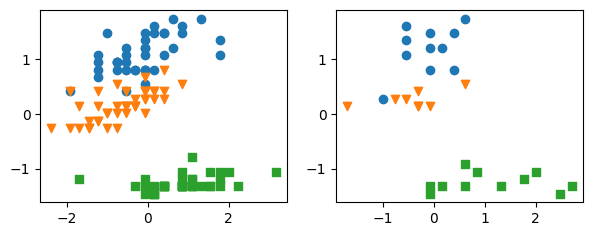

In [63]:
fig, ax = plt.subplots(1,2, figsize=(7,2.5))
ax[0].scatter(xTrain[yTrain==2,0] , xTrain[yTrain==2,1])
ax[0].scatter(xTrain[yTrain==1,0] , xTrain[yTrain==1,1],marker='v')
ax[0].scatter(xTrain[yTrain==0,0] , xTrain[yTrain==0,1],marker='s')
ax[1].scatter(xTest[yTest==2,0] , xTest[yTest==2,1])
ax[1].scatter(xTest[yTest==1,0] , xTest[yTest==1,1],marker='v')
ax[1].scatter(xTest[yTest==0,0] , xTest[yTest==0,1],marker='s')

#Scratch Implementation

In [64]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')


In [65]:
def toOneHot(y,numClasses):
  yOneHot = torch.FloatTensor(y.size(0), numClasses)
  yOneHot.zero_()
  yCPU = y.to(torch.device('cpu'))
  yOneHot.scatter_(1,yCPU.view(-1,1).long(),1).float()
  return yOneHot.to(DEVICE)

def softmax(z):
  return (torch.exp(z.t())/torch.sum(torch.exp(z),dim=1)).t()

def crossEntropy(softmax,yTarget):
  return -torch.sum(torch.log(softmax)* yTarget, dim=1)


In [66]:
class softmaxRegression():
  def __init__(self,numFeatures,numClasses):
    self.numFeatures = numFeatures
    self.numClasses = numClasses
    self.weights = torch.zeros(numClasses, numFeatures, # nC * nF
                               dtype=torch.float32, device=DEVICE)
    self.bias = torch.zeros(numClasses, dtype = torch.float32, device=DEVICE)

  def forward(self,x):
    logits = torch.mm(x,self.weights.t()) + self.bias
    probas = softmax(logits)
    return logits,probas

  def backward(self,x,y,probas):
    gradLossWrtW = -torch.mm(x.t(), y - probas).t()
    gradLossWrtB = -torch.sum(y-probas)
    return gradLossWrtW, gradLossWrtB

  def predict(self,x):
    logits, probas = self.forward(x)
    labels = torch.argmax(probas,dim=1)
    return labels

  def evaluate(self,x,y):
    pred  = self.predict(x).float()
    acc = torch.sum(pred.view(-1) == y.float()).item() / y.size(0)
    return acc

  def train(self,x,y,numEpoch, learningRate = 0.1):
    epochCost = []
    yOneHot = toOneHot(y,self.numClasses)
    for e in range(numEpoch):

      logits,probas = self.forward(x)
      gradW, gradB = self.backward(x,yOneHot,probas)
      self.weights-=learningRate* gradW / y.size(0)
      self.bias-=learningRate*gradB / y.size(0)
      acc = self.evaluate(x,y)

      logits,probas = self.forward(x)
      cost = torch.mean(crossEntropy(probas, yOneHot))
      epochCost.append(cost)
    return epochCost


In [67]:
xTrain = xTrain.to(DEVICE)
yTrain = yTrain.to(DEVICE)

model = softmaxRegression(2,3)
epochCost = model.train(xTrain,yTrain,50,learningRate=0.1)



In [68]:
epochCost

[tensor(1.0571),
 tensor(1.0189),
 tensor(0.9837),
 tensor(0.9513),
 tensor(0.9215),
 tensor(0.8940),
 tensor(0.8687),
 tensor(0.8453),
 tensor(0.8236),
 tensor(0.8036),
 tensor(0.7851),
 tensor(0.7678),
 tensor(0.7518),
 tensor(0.7368),
 tensor(0.7228),
 tensor(0.7098),
 tensor(0.6975),
 tensor(0.6860),
 tensor(0.6752),
 tensor(0.6651),
 tensor(0.6555),
 tensor(0.6465),
 tensor(0.6379),
 tensor(0.6298),
 tensor(0.6221),
 tensor(0.6149),
 tensor(0.6079),
 tensor(0.6014),
 tensor(0.5951),
 tensor(0.5891),
 tensor(0.5834),
 tensor(0.5780),
 tensor(0.5728),
 tensor(0.5678),
 tensor(0.5630),
 tensor(0.5585),
 tensor(0.5541),
 tensor(0.5499),
 tensor(0.5458),
 tensor(0.5419),
 tensor(0.5382),
 tensor(0.5346),
 tensor(0.5311),
 tensor(0.5278),
 tensor(0.5246),
 tensor(0.5214),
 tensor(0.5184),
 tensor(0.5155),
 tensor(0.5127),
 tensor(0.5100)]

In [69]:
print("\nModel Parameters:\n")
print(' Weights: %s' % model.weights)
print(' Bias: %s' % model.bias)


Model Parameters:

 Weights: tensor([[ 0.5539, -1.0034],
        [-0.5558,  0.0563],
        [ 0.0020,  0.9471]])
 Bias: tensor([-1.5497e-08, -1.5497e-08, -1.5497e-08])


##Evaluating the Model

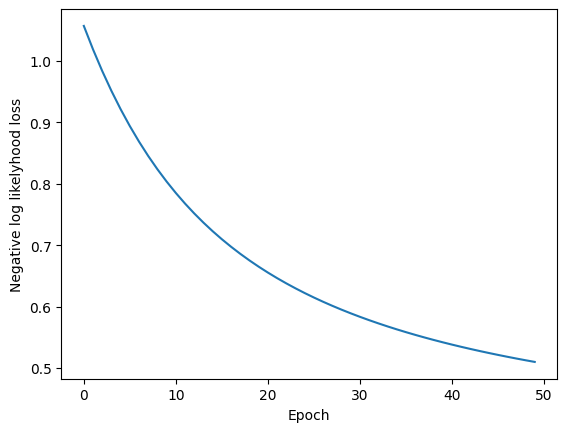

In [70]:
plt.plot(epochCost)
plt.ylabel('Negative log likelyhood loss')
plt.xlabel('Epoch')
plt.show()

In [71]:
xTest = xTest.to(DEVICE)
yTest = yTest.to(DEVICE)

testAcc = model.evaluate(xTest,yTest)
print('Test set Accuracy: %.2f%%' % (testAcc*100))

Test set Accuracy: 86.67%


In [76]:
from matplotlib.colors import ListedColormap
import numpy as np

def plotDecisionRegions(X,y,classifier, resolution=0.02):

  markers = ['s','x','o','^','v']
  colors  = ['red','blue','lightgreen','gray','cyan']
  cmap = ListedColormap(colors[:len(np.unique(y))])

  x1min , x1max = X[: ,0].min() -1, X[:,0].max()+1
  x2min , x2max = X[: ,1].min() -1, X[:,1].max()+1
  xx1, xx2 = np.meshgrid(np.arange(x1min,x1max,resolution),
                         np.arange(x2min,x2max,resolution))
  tensor = torch.tensor(np.array([xx1.ravel(),xx2.ravel()]).T).float()
  logits, probas = classifier.forward(tensor)
  z = np.argmax(probas.detach().numpy(),axis=1)
  z = z.reshape(xx1.shape)

  plt.contourf(xx1,xx2,z, alpha=0.4,cmap=cmap)
  plt.xlim(xx1.min(),xx1.max())
  plt.ylim(xx2.min(),xx2.max())

  for idx,cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y==cl,0], y=X[y == cl,1],
                alpha=0.8,color=cmap(idx),
                edgecolor = 'black',
                marker = markers[idx],
                label = cl)

<ipython-input-76-252ace65f377>:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==cl,0], y=X[y == cl,1],


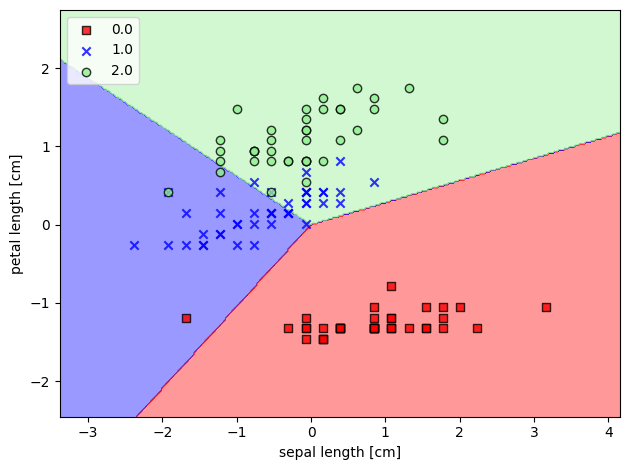

In [77]:
plotDecisionRegions(xTrain,yTrain,classifier=model)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc= 'upper left')

plt.tight_layout()
plt.show()